In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from mlxtend.data import loadlocal_mnist

import random

### Dataset Preparation

In [31]:
raw_train_images, raw_train_labels = loadlocal_mnist(
    images_path='../ats_comp_vision/mnist-dataset/emnist-letters-train-images-idx3-ubyte',
    labels_path='../ats_comp_vision/mnist-dataset/emnist-letters-train-labels-idx1-ubyte'
)

print(f"Raw dataset shape: {raw_train_images.shape}")


Raw dataset shape: (124800, 784)


In [32]:
train_images, train_labels = [], []
np.random.seed(42)

for i in range(1, 27):
    indices = np.where(raw_train_labels == i)[0]
    if len(indices) >= 100:
        selected = np.random.choice(indices, size=100, replace=False)
        train_images.append(raw_train_images[selected])
        train_labels.append(raw_train_labels[selected])
    else:
        print(f"Skipping class {i}: only {len(indices)} samples")

train_images = np.vstack(train_images)
train_labels = np.hstack(train_labels)

print("After selection:", train_images.shape, train_labels.shape)


After selection: (2600, 784) (2600,)


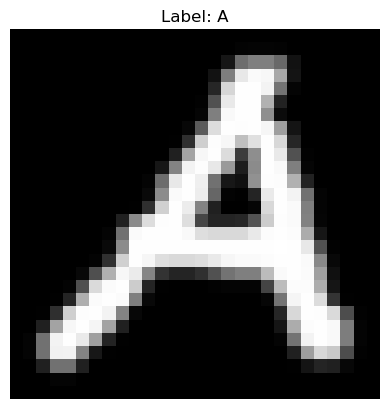

In [33]:
plt.imshow(train_images[1].reshape(28, 28).T, cmap='gray')
plt.title(f"Label: {chr(train_labels[1] + 64)}")
plt.axis('off')
plt.show()


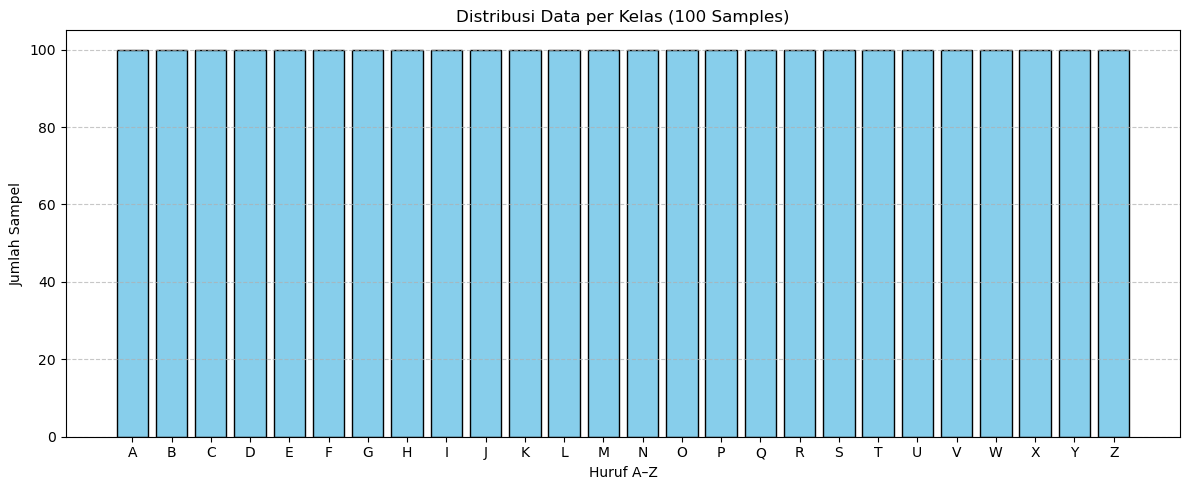

In [34]:
unique, counts = np.unique(train_labels, return_counts=True)
letters = [chr(label + 64) for label in unique]

plt.figure(figsize=(12, 5))
plt.bar(letters, counts, color='skyblue', edgecolor='black')
plt.title("Distribusi Data per Kelas (100 Samples)")
plt.xlabel("Huruf A–Z")
plt.ylabel("Jumlah Sampel")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [35]:
shuffle_idx = np.random.permutation(len(train_labels))
train_images = train_images[shuffle_idx]
train_labels = train_labels[shuffle_idx]


### Feature Extraction

In [36]:
from skimage.feature import hog

In [37]:
def extract_hog_features(images):
    features = []
    for img in images:
        feat, _ = hog(
            img.reshape(28, 28), 
            orientations=9, 
            pixels_per_cell=(8, 8), 
            cells_per_block=(2, 2), 
            block_norm='L2', 
            visualize=True
        )
        features.append(feat)
    return np.array(features)

X = extract_hog_features(train_images)
y = train_labels

print(f"Feature shape: {X.shape}")


Feature shape: (2600, 144)


### Classification

In [38]:

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(2080, 144) (2080,) (520, 144) (520,)


In [40]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, make_scorer
)

In [41]:
param_grid = {
    'C': [0.1, 1, 3.2, 5.0, 2.4, 10.0],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto']
}

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro'),
    'f1': make_scorer(f1_score, average='macro')
}

clf = SVC()
grid_search = GridSearchCV(clf, param_grid, scoring=scoring, cv=5, refit='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


/home/marcel/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/marcel/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/home/marcel/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/marcel/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/home/marcel/.local/lib/python3.10/site-pa

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 3.2, 5.0, 2.4, 10.0],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'linear']},
             refit='f1',
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'f1': make_scorer(f1_score, response_method='predict', average=macro),
                      'precision': make_scorer(precision_score, response_method='predict', average=macro),
                      'recall': make_scorer(recall_score, response_method='predict', average=macro)},
             verbose=1)

### Evaluation

In [42]:
best_model = grid_search.best_estimator_
pred_test = best_model.predict(X_test)

print("=== Evaluation on Test Data ===")
print("Accuracy:", accuracy_score(y_test, pred_test))
print("Precision:", precision_score(y_test, pred_test, average='macro'))
print("Recall:", recall_score(y_test, pred_test, average='weighted'))
print("F1 Score:", f1_score(y_test, pred_test, average='weighted'))


=== Evaluation on Test Data ===
Accuracy: 0.7923076923076923
Precision: 0.7969239573614258
Recall: 0.7923076923076923
F1 Score: 0.7922198264555186


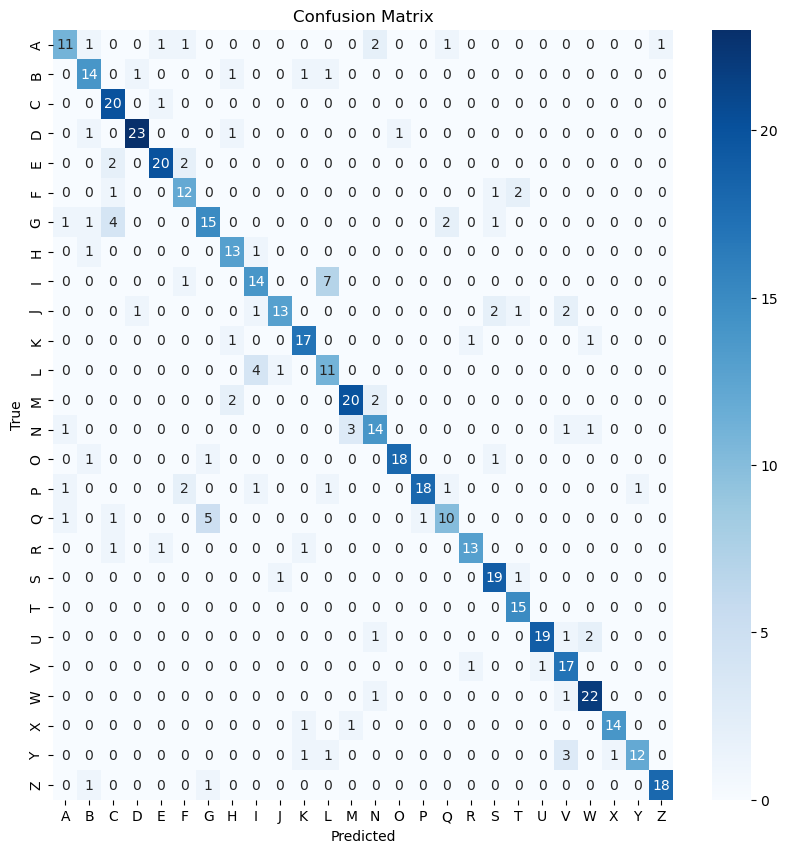

In [43]:
conf_mat = confusion_matrix(y_test, pred_test)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", 
            xticklabels=[chr(c+64) for c in np.unique(y_test)], 
            yticklabels=[chr(c+64) for c in np.unique(y_test)])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


### testing model

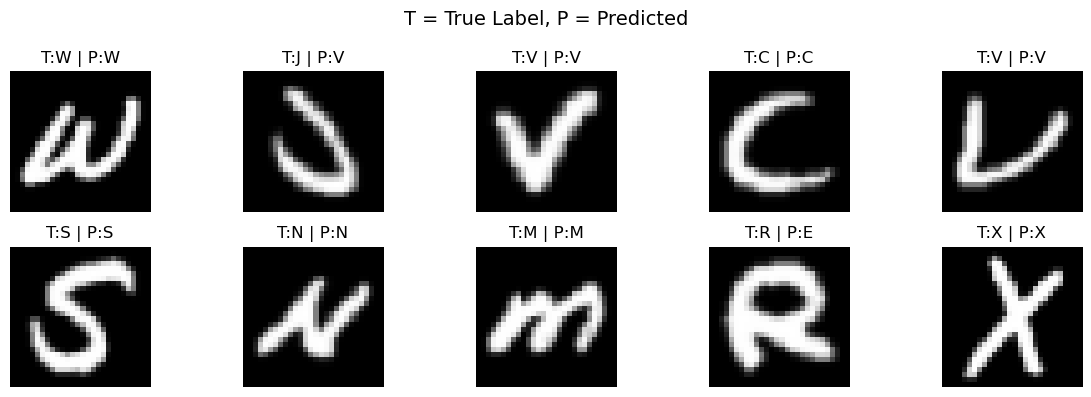

In [44]:
indices = random.sample(range(len(X_test)), 10)

plt.figure(figsize=(12, 4))
for i, idx in enumerate(indices):
    img = train_images[idx + int(len(train_images) * 0.8)].reshape(28, 28).T
    true_label = y_test[idx]
    pred_label = pred_test[idx]
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"T:{chr(true_label+64)} | P:{chr(pred_label+64)}")
    plt.axis('off')

plt.suptitle("T = True Label, P = Predicted", fontsize=14)
plt.tight_layout()
plt.show()
